<a href="https://colab.research.google.com/github/rgilyard/parallel-edge-detection/blob/main/parallel_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge Detection and Parallel Processing

## Import Libraries

In [16]:
import torch
from PIL import Image, ImageOps
import os
import numpy as np

In [17]:
print("Number of available GPUs:", torch.cuda.device_count())

Number of available GPUs: 0


### Check that CUDA is available

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use index 1 instead of the default index 0
else:
    device = torch.device("cpu")

print("using", device, "device")
print(device)

using cpu device
cpu


## Set image folder paths

In [19]:
# For colab
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
image_folder = '/content/drive/My Drive/COMP 620 Group Project/edge_gpu/images'


# Input and output paths
# image_folder = 'images'
input_folder_path = 'input'
output_folder_path = 'output'

# Dummy path for multiple sequential loading
dummy = 'dummy_class'
single = 'single_images'

# Multiple image paths
img_16 = '16_images'
img_64 = '64_images'
img_256 = '256_images'
img_1024 = '1024_images'
img_4096 = '4096_images'
# multiple_image_paths = [img_16, img_64, img_256, img_1024, img_4096]
multiple_image_paths = [img_16, img_64, img_256, img_1024]

# Single image paths
x_small = 'pipe.png'
small = 'cardsharps.png'
med = 'washington.png'
large = 'pedlar.jpg'
x_large = 'pearl.png'
# single_image_paths = [x_small, small, med, large, x_large]
single_image_paths = [x_small, small, med, large]

# Lists for the algorithms to run, input then output paths
# Should I do input and output as a tuple, and then the type of data as a title as a dict?
# I'll do this better later
multiple_sequential_paths = []
multiple_parallel_paths = []
single_sequential_paths = []
single_parallel_paths = []

# Make multiple image path lists
for path in multiple_image_paths:
    sequential = (os.path.join(image_folder, input_folder_path, path, dummy, ''), \
                  os.path.join(image_folder, output_folder_path, path, ''))
    multiple_sequential_paths.append(sequential)
    parallel = (os.path.join(image_folder, input_folder_path, path, ''), \
                  os.path.join(image_folder, output_folder_path, path, ''))
    multiple_parallel_paths.append(parallel)
                
# Make single image path lists
for path in single_image_paths:
    sequential = (os.path.join(image_folder, input_folder_path, single, path), \
                  os.path.join(image_folder, output_folder_path, single, path))
    single_sequential_paths.append(sequential)
    parallel = (os.path.join(image_folder, input_folder_path, single, path), \
                  os.path.join(image_folder, output_folder_path, single, path))
    single_parallel_paths.append(parallel)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set parameters

In [20]:
# This prevents pillow from throwing a DecompressionBombError for the largest images
Image.MAX_IMAGE_PIXELS = 10_000_000_000

patch_size = 1024
batch_size = 32 # Number of image in a dataloader batch
num_workers = 0 # Parallelization for dataloading (CPU, not GPU)

### Set constants

In [21]:
# ADD CONSTANTS FOR PARALLEL AND SEQUENTIAL KERNELS, maybe define kernel separately

# Sequential Sobel kernels
sobel_x_kernel_seq = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
sobel_y_kernel_seq = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

# Sobel operator kernels for horizontal and vertical edges (parallel)
sobel_x_kernel_par = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
sobel_y_kernel_par = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)

# Unsqueeze the Sobel kernels to match the shape
# (C_out, C_in, H_kernel, W_kernel)
sobel_x_kernel_expanded = sobel_x_kernel_par.unsqueeze(0).unsqueeze(0).to(device)
sobel_y_kernel_expanded = sobel_y_kernel_par.unsqueeze(0).unsqueeze(0).to(device)
# sobel_y_kernel_expanded = sobel_y_kernel_par.unsqueeze(0).unsqueeze(0).to('cuda')

### Additional Functions

In [22]:
import torchvision.transforms.functional as F

# Function to save tensor to image
def save_image_from_tensor(tensor_img, output_path):
    # Convert the tensor back to a PIL image
    pil_img = F.to_pil_image(tensor_img)
    
    # Save the image to the output folder
    pil_img.save(output_path)

## Sequential Edge Detection Algorithms

#### Libraries

In [23]:
import glob
from scipy import ndimage
import gc

### Sequential Single Image Algorithm

In [24]:
# Edge detection for single image
def sequential_single(file_path, output_folder, patch_size=patch_size, overlap=1):
    # Load the image and convert it to grayscale
    img = Image.open(file_path).convert("L")
    width, height = img.size

    # Create an empty output image
    output_img = Image.new("L", (width, height))

    # Calculate the number of patches in both dimensions
    num_patches_w = math.ceil((width - patch_size) / (patch_size - overlap)) + 1
    num_patches_h = math.ceil((height - patch_size) / (patch_size - overlap)) + 1

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # Extract a patch from the large image
            left = j * (patch_size - overlap)
            upper = i * (patch_size - overlap)
            right = min(left + patch_size, width)
            lower = min(upper + patch_size, height)
            patch = img.crop((left, upper, right, lower))

            # Convert the patch to a numpy array
            patch_array = np.asarray(patch, dtype=np.float32)

            # Apply Sobel kernels to the patch
            edge_x = ndimage.convolve(patch_array, sobel_x_kernel_seq, mode="constant", cval=0)
            edge_y = ndimage.convolve(patch_array, sobel_y_kernel_seq, mode="constant", cval=0)

            # Calculate the magnitude of the gradients
            edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)

            # Normalize the edge magnitude to the range [0, 255]
            edge_magnitude = edge_magnitude.astype(np.uint8)

            # Create a PIL Image from the numpy array
            edge_patch = Image.fromarray(edge_magnitude)

            # Paste the edge-detected patch into the output image
            output_img.paste(edge_patch, (left, upper))
    
    del img
    gc.collect()

    # Save the edge-detected image to the output folder
    output_img.save(output_folder)

### Sequential Multiple Image Algorithm

In [25]:
# Sequential algorithm for all the images in a folder
def sequential_multiple(input_folder, output_folder):
    # Get the list of image file paths in the input folder
    image_files = glob.glob(os.path.join(input_folder, "*"))

    # Iterate through each image file
    for index, file_path in enumerate(image_files):
        # Load the image and convert it to grayscale
        img = Image.open(file_path).convert("L")

        # Convert the image to a numpy array
        img_array = np.asarray(img, dtype=np.float32)

        # Apply Sobel kernels to the image
        edge_x = ndimage.convolve(img_array, sobel_x_kernel_seq, mode="constant", cval=0)
        edge_y = ndimage.convolve(img_array, sobel_y_kernel_seq, mode="constant", cval=0)

        # Calculate the magnitude of the gradients
        edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)

        # Normalize the edge magnitude to the range [0, 255]
        edge_magnitude = edge_magnitude.astype(np.uint8)

        # Create a PIL Image from the numpy array
        edge_image = Image.fromarray(edge_magnitude)

        # Save the edge-detected image to the output folder
        img_output_path = os.path.join(output_folder, f'edge_{index}.png')
        edge_image.save(img_output_path)

## Parallel Edge Detection Algorithm

#### Libraries

In [26]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn.functional import conv2d
import math
from torchvision.transforms.functional import to_pil_image

### Parallel Single Image Algorithm

In [27]:
def parallel_single(input_image_path, output_image_path, patch_size=patch_size, overlap=2):
    # Load the large image and convert it to grayscale
    large_img = Image.open(input_image_path).convert("L")
    
    width, height = large_img.size
    # Calculate the number of patches required to cover the image, get the padding size to be added
    pad_width = (math.ceil((width - overlap) / (patch_size - overlap)) - 1) * (patch_size - overlap) + patch_size - width
    pad_height = (math.ceil((height - overlap) / (patch_size - overlap)) - 1) * (patch_size - overlap) + patch_size - height

    # Add padding to the image
    large_img = ImageOps.expand(large_img, (0, 0, pad_width, pad_height), fill=0)
    # large_img.save(output_image_path)
    
    # New widtch and height
    new_width, new_height = large_img.size

    # Calculate the number of patches along width and height
    # Come back and fix this so it isn't calculated twice
    num_patches_w = math.ceil((new_width - overlap) / (patch_size - overlap))
    num_patches_h = math.ceil((new_height - overlap) / (patch_size - overlap))

    # Create an empty image to store the edge-detected result
    output_img = Image.new("L", (new_width, new_height))
    
    patches = []

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # Extract a patch from the large image
            left = j * (patch_size - overlap)
            upper = i * (patch_size - overlap)
            right = min(left + patch_size, new_width)
            lower = min(upper + patch_size, new_height)
            patch = large_img.crop((left, upper, right, lower))

            # Convert the patch to a tensor
            patch_tensor = transforms.ToTensor()(patch)
            
            # Append the patch tensor to the patches list
            patches.append(patch_tensor)

    del large_img
    gc.collect()
            
    # Split the patches list into smaller sublists (batches)
    patch_batches = [patches[i:i + batch_size] for i in range(0, len(patches), batch_size)]
        
    for batch_idx, patch_batch in enumerate(patch_batches):
        # Stack the patch tensors together into a single tensor
        patches_tensor = torch.stack(patch_batch).to(device)
        
        # Convolve the patches with the Sobel kernels
        edge_x = conv2d(patches_tensor, sobel_x_kernel_expanded, padding=1)
        edge_y = conv2d(patches_tensor, sobel_y_kernel_expanded, padding=1)

        # Combine the horizontal and vertical edges using the L2 norm
        #edge_detected_patches = torch.sqrt(edge_x ** 2 + edge_y ** 2).squeeze()
        edge_detected_patches = torch.sqrt(edge_x ** 2 + edge_y ** 2)

        # Process the edge-detected patches and paste them into the output image
        for i, edge_detected_patch in enumerate(edge_detected_patches):
            # Convert the edge-detected patch back to a PIL image
            edge_detected_patch = to_pil_image(edge_detected_patch.cpu())
            # Crop the patch to remove the top and left two pixels
            edge_detected_patch = edge_detected_patch.crop((2, 2, edge_detected_patch.width, edge_detected_patch.height))

            # Calculate the index of the patch in the original patches list
            original_patch_idx = batch_idx * batch_size + i

            # Calculate the position of the patch in the output image
            row_idx = original_patch_idx // num_patches_w
            col_idx = original_patch_idx % num_patches_w
            left = col_idx * (patch_size - overlap)
            upper = row_idx * (patch_size - overlap)

            # Paste the edge-detected patch into the output image
            output_img.paste(edge_detected_patch, (left, upper))
            del edge_detected_patch
        # Send the tensor back to the cpu to save space
        patches_tensor = patches_tensor.cpu()
        edge_x = edge_x.cpu()
        edge_y = edge_y.cpu()
        edge_detected_patches = edge_detected_patches.cpu()
        del patches_tensor
        del edge_x
        del edge_y
        del edge_detected_patches
        torch.cuda.empty_cache()
        gc.collect()

    # Trim the output image to its original size before saving
    output_img = output_img.crop((0, 0, width, height))
    # Save the edge-detected large image
    output_img.save(output_image_path)
    
    # Garbage collect
    del output_img
    del patch_batches
    gc.collect()

### Parallel Multiple Image Algorithm

In [28]:
# Finds edges for all the images in a folder in parallel
def parallel_multiple(img_folder, output_folder):
    # Define the transformation pipeline (it's not much 
    # a pipline, because I'm only converting to tensors)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    
    # Create an ImageFolder dataset
    dataset = ImageFolder(root=img_folder, transform=transform)
    
    # Create a DataLoader to handle batching
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=num_workers)
    
    for batch_idx, (data, _) in enumerate(dataloader):
        # Move the data to the GPU
        data = data.to(device)
        
        # Convolve the image with the Sobel kernels
        edge_x = conv2d(data, sobel_x_kernel_expanded, padding=1)
        edge_y = conv2d(data, sobel_y_kernel_expanded, padding=1)

        # Combine the horizontal and vertical edges using the L2 norm
        edge_detected_batch = torch.sqrt(edge_x ** 2 + edge_y ** 2).squeeze()

        # Save each image
        for index, edge_detected_image in enumerate(edge_detected_batch):
            img_output_path = os.path.join(output_folder, f'edge_{batch_idx * batch_size + index}.png')
            save_image_from_tensor(edge_detected_image.cpu(), img_output_path)
        # Send the data back to the cpu to save space
        data = data.cpu()
        edge_detected_batch = edge_detected_batch.cpu()
        edge_x = edge_x.cpu()
        edge_y = edge_y.cpu()        
        del data
        del edge_detected_batch
        del edge_x
        del edge_y
        torch.cuda.empty_cache()
        gc.collect()

    del dataloader
    del transform
    del dataset
    torch.cuda.empty_cache()
    gc.collect()

## Run Algorithms and Measure for Speed

In [29]:
import timeit

# Function to time functions over all image paths
# and return a list of times
def time_function(function, paths):
    print('timing functions')
    time_list = []
    for path in paths:
        print('.')
        # Record the start time
        start_time = timeit.default_timer()
        # Run the function
        function(path[0], path[1])
        # End timer, calculate time, append time to list
        end_time = timeit.default_timer()
        elapsed_time = end_time - start_time
        time_list.append(elapsed_time)
    print()
    return time_list

In [30]:
# List of multiple, sequential times
mult_seq_timings = time_function(sequential_multiple, multiple_sequential_paths)

# List of multiple, parallel times
mult_par_timings = time_function(parallel_multiple, multiple_parallel_paths)

# List of single, sequential times
sing_seq_timings = time_function(sequential_single, single_sequential_paths)

# List of single, parallel times
sing_par_timings = time_function(parallel_single, single_parallel_paths)

timing functions
.
.
.
.

timing functions
.
.
.
.

timing functions
.
.
.
.

timing functions
.
.
.
.



In [31]:
print(mult_seq_timings)
print(mult_par_timings)
print(sing_seq_timings)
print(sing_par_timings)

[21.83500571699983, 92.25936041299997, 297.650070979, 1101.965905793]
[11.42549788999986, 53.73633763599992, 226.56319445000008, 841.7919387709999]
[0.10424345699993864, 0.31192213799977253, 2.9989817979999316, 22.85696751999967]
[0.3079084219998549, 0.4709184749999622, 2.955022701999951, 19.18602335000014]


### Print Figures

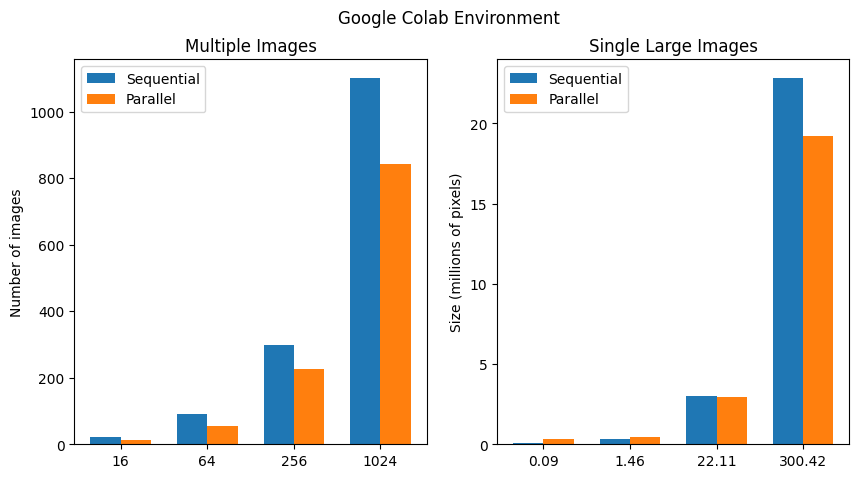

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Create the bar graph with two subfigures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Subfigure 1: Multiple images
width = 0.35
labels1 = ['16', '64', '256', '1024']
x1 = np.arange(len(labels1))

ax1.bar(x1 - width/2, mult_seq_timings, width, label='Sequential')
ax1.bar(x1 + width/2, mult_par_timings, width, label='Parallel')

ax1.set_ylabel('Time (seconds)')
ax1.set_ylabel('Number of images')
ax1.set_title('Multiple Images')
ax1.set_xticks(x1)
ax1.set_xticklabels(labels1)
ax1.legend()

# Subfigure 2: Single large images
labels2 = ['0.09', '1.46', '22.11', '300.42']
x2 = np.arange(len(labels2))

ax2.bar(x2 - width/2, sing_seq_timings, width, label='Sequential')
ax2.bar(x2 + width/2, sing_par_timings, width, label='Parallel')

ax2.set_ylabel('Time (seconds)')
ax2.set_ylabel('Size (millions of pixels)')
ax2.set_title('Single Large Images')
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2)
ax2.legend()

# Add a title for the entire figure
fig.suptitle('Google Colab Environment')

# Save the figure to a file
plt.savefig('output_image.png', dpi=300, bbox_inches='tight')

# Optionally, display the plot
plt.show()

## Run Algorithms and Measure for Space

### Print Figures